In [ ]:
import torch
import math
import numpy as np

def flux_step(
    eta: float,
    sigmas: torch.Tensor,
    index: int,
):
    sigma = sigmas[index]
    dsigma = sigmas[index + 1] - sigma
    sigma_next = sigmas[index + 1]
    # prev_sample_mean = latents + dsigma * model_output

    # pred_original_sample = latents - sigma * model_output

    delta_t = sigma - sigmas[index + 1]
    ## Dance-GRPO
    # std_dev_t = eta * np.sqrt(sigma)
    ## Flow-GRPO
    sigma_max = sigmas[1].item()
    if sigma == 1:
        sigma_ = sigma_max
    else:
        sigma_ = sigma
    std_dev_t = math.sqrt(sigma / (1 - sigma_)) * eta

    # score_estimate = -(latents-pred_original_sample*(1 - sigma))/sigma**2
    # log_term = -0.5 * eta**2 * score_estimate
    # prev_sample_mean = prev_sample_mean + log_term * dsigma
    log_term = 0.5 * std_dev_t**2 / sigma
    prev_sample_mean = sigma_next + log_term * dsigma
    #print(sigma_next, log_term * dsigma, std_dev_t* np.sqrt(delta_t))

    #prev_sample = prev_sample_mean + torch.randn_like(prev_sample_mean) * std_dev_t

    noise_level = math.sqrt(prev_sample_mean**2 + std_dev_t**2 * delta_t)
    noise_level2 = math.sqrt(sigma_next**2 + std_dev_t**2 * delta_t**2/sigma + (std_dev_t**2 * delta_t)**2/(4*sigma**2)) # eq. 10
    #print(noise_level, noise_level2)
    return noise_level
        
def sd3_time_shift(shift, t):
    return (shift * t) / (1 + (shift - 1) * t)
    

In [18]:
eta = 0.7
sampling_steps = 16
shift = 1.0
sigma_schedule = torch.linspace(1, 0, sampling_steps + 1)
sigma_schedule = sd3_time_shift(shift, sigma_schedule)

sigmas = sigma_schedule.cpu().numpy()
print("sigmas:", sigmas)

# real_noise_norm = np.array([352.2909, 343.6595, 334.1686, 323.7835, 312.3987, 299.6706, 284.4537, 268.2900, 249.9028, 229.3254, 205.6004, 178.3286, 147.3019, 115.1728, 93.5203, 126.5936])
# real_noise_norm = real_noise_norm / 360
errors = []
for index in range(sampling_steps):
    noise_level = flux_step(eta, sigmas, index)
    print(f"Noise level at step {index}: {noise_level:.4f}, ideal: {sigmas[index + 1]:.4f}")
    errors.append(noise_level**2 - sigmas[index + 1]**2)
accumulated_error = np.sqrt(sum(errors))
print(f"Accumulated error: {accumulated_error:.4f}")



sigmas: [1.     0.9375 0.875  0.8125 0.75   0.6875 0.625  0.5625 0.5    0.4375
 0.375  0.3125 0.25   0.1875 0.125  0.0625 0.    ]
0.9846604744783858 0.9846604744783859
Noise level at step 0: 0.9847, ideal: 0.9375
0.9253512846481601 0.92535128464816
Noise level at step 1: 0.9254, ideal: 0.8750
0.8309482535031889 0.8309482535031889
Noise level at step 2: 0.8309, ideal: 0.8125
0.7611686920635778 0.7611686920635778
Noise level at step 3: 0.7612, ideal: 0.7500
0.6957471253983015 0.6957471253983015
Noise level at step 4: 0.6957, ideal: 0.6875
0.631783982069821 0.631783982069821
Noise level at step 5: 0.6318, ideal: 0.6250
0.5684872714298692 0.5684872714298692
Noise level at step 6: 0.5685, ideal: 0.5625
0.5055689863905816 0.5055689863905816
Noise level at step 7: 0.5056, ideal: 0.5000
0.442913383885608 0.442913383885608
Noise level at step 8: 0.4429, ideal: 0.4375
0.3804849894023335 0.3804849894023335
Noise level at step 9: 0.3805, ideal: 0.3750
0.31830645610794644 0.3183064561079464
Noise l

0.9375 -0.045 0.3
0.875 -0.045000000000000005 0.2904737509655563
0.8125 -0.0225 0.1984313483298443
0.75 -0.014999999999999994 0.15612494995995993
0.6875 -0.011249999999999998 0.12990381056766578
0.625 -0.009 0.11124297730643494
0.5625 -0.007499999999999998 0.09682458365518541
0.5 -0.0064285714285714285 0.08504200642707613
0.4375 -0.005625 0.075
0.375 -0.004999999999999998 0.06614378277661476
0.3125 -0.0045 0.05809475019311125
0.25 -0.0040909090909090895 0.05056498968474315
0.1875 -0.003749999999999999 0.043301270189221926
0.125 -0.0034615384615384608 0.0360288346061446
0.0625 -0.003214285714285714 0.02834733547569204
0.0 -0.0029999999999999988 0.01936491673103708
0.9375 -0.125 0.5
0.875 -0.12500000000000003 0.4841229182759271
0.8125 -0.06250000000000001 0.33071891388307384
0.75 -0.041666666666666664 0.2602082499332666
0.6875 -0.031249999999999997 0.21650635094610965
0.625 -0.025 0.18540496217739158
0.5625 -0.020833333333333332 0.1613743060919757
0.5 -0.01785714285714286 0.1417366773784

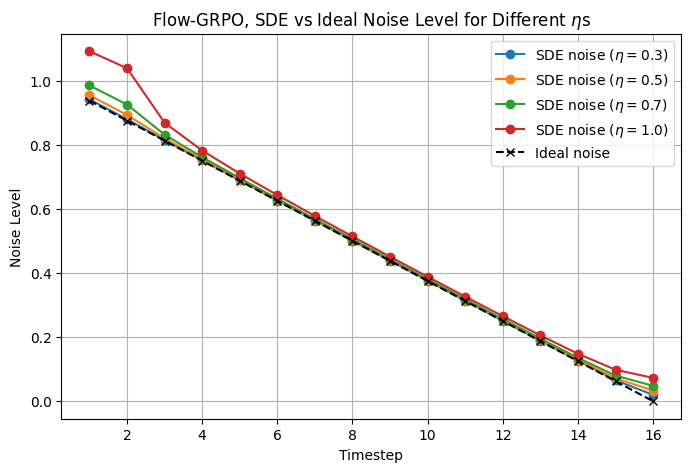

In [16]:
import matplotlib.pyplot as plt

etas = [0.3, 0.5, 0.7, 1.0]
sampling_steps = 16
shift = 1.0
sigma_schedule = torch.linspace(1, 0, sampling_steps + 1)
sigma_schedule = sd3_time_shift(shift, sigma_schedule)
sigmas = sigma_schedule.cpu().numpy()

plt.figure(figsize=(8, 5))

for eta in etas:
    sde_noise_levels = []
    for idx in range(sampling_steps):
        sde_noise_levels.append(flux_step(eta, sigmas, idx))
    plt.plot(range(1, sampling_steps + 1), sde_noise_levels, marker='o', label=fr'SDE noise ($\eta={eta}$)')

plt.plot(range(1, sampling_steps + 1), sigmas[1:], marker='x', linestyle='--', color='black', label='Ideal noise')

plt.xlabel('Timestep')
plt.ylabel('Noise Level')
plt.title(fr'Flow-GRPO, SDE vs Ideal Noise Level for Different $\eta$s')
plt.legend()
plt.grid(True)
# plt.savefig(f'dance-{sampling_steps}steps.pdf', bbox_inches='tight', dpi=300)
plt.show()


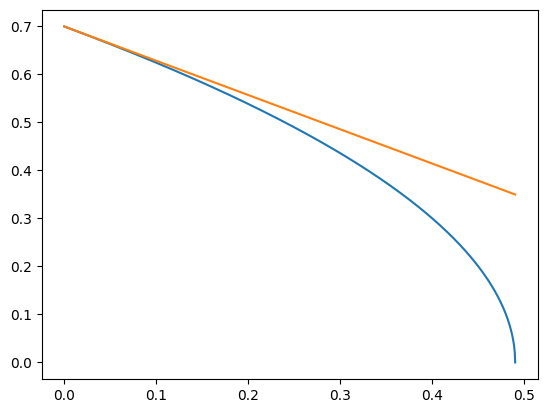

In [290]:
t = 0.7
x = np.linspace(0, t**2, 1000)
plt.plot(x, np.sqrt(t**2 - x))
plt.plot(x, t - x/2/t)